# About this kernel

In this kernel, I would like to try bayesian optimisation for hyperparameter tuning for neural network (NN) and random forest (RF). I will apply the results to my another public kernel [Blending NN and RF][1]. The feature engineering and NN parts are copied from bestpredict's kernel [Location EDA 8eb410][2] whilst the random forest (RF) regressor is proposed in Dimension's kernel [[NFL] - [001]- [Feature selection]][3]. Please correct me if you have found any mistake. Thank you very much.

[1]: https://www.kaggle.com/gogo827jz/blending-nn-and-rf
[2]: https://www.kaggle.com/bestpredict/location-eda-8eb410
[3]: https://www.kaggle.com/coolcoder22/nfl-001-feature-selection

In [ ]:
import os
# TRAIN_ABLE_FALSE=True
# if TRAIN_ABLE_FALSE:
#     os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import numpy as np
import pandas as pd
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization,LeakyReLU,PReLU,ELU,ThresholdedReLU,Concatenate
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from  keras.callbacks import EarlyStopping,ModelCheckpoint
from tqdm import tqdm_notebook
from functools import partial
import datetime
import warnings
warnings.filterwarnings('ignore')

TRAIN_OFFLINE = False


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# train = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})
if TRAIN_OFFLINE:
    train = pd.read_csv('../input/train.csv', dtype={'WindSpeed': 'object'})
else:
    train = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})
    

In [ ]:
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

In [ ]:
train.head()

In [ ]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def strtofloat(x):
    try:
        return float(x)
    except:
        return -1

def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

def OffensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def DefensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def orientation_to_cat(x):
    x = np.clip(x, 0, 360 - 1)
    try:
        return str(int(x/15))
    except:
        return "nan"
def preprocess(train):
    ## GameClock
    train['GameClock_sec'] = train['GameClock'].apply(strtoseconds)
    train["GameClock_minute"] = train["GameClock"].apply(lambda x : x.split(":")[0]).astype("object")

    ## Height
    train['PlayerHeight_dense'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

    ## Time
    train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

    train['TimeDelta'] = train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    train['PlayerBirthDate'] = train['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

    ## Age
    seconds_in_year = 60*60*24*365.25
    train['PlayerAge'] = train.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    train["PlayerAge_ob"] = train['PlayerAge'].astype(np.int).astype("object")

    ## WindSpeed
    train['WindSpeed_ob'] = train['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    train['WindSpeed_ob'] = train['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    train['WindSpeed_ob'] = train['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    train['WindSpeed_dense'] = train['WindSpeed_ob'].apply(strtofloat)

    ## Weather
    train['GameWeather_process'] = train['GameWeather'].str.lower()
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    train['GameWeather_dense'] = train['GameWeather_process'].apply(map_weather)

    ## Rusher
    train['IsRusher'] = (train['NflId'] == train['NflIdRusher'])
    train['IsRusher_ob'] = (train['NflId'] == train['NflIdRusher']).astype("object")
    temp = train[train["IsRusher"]][["Team", "PlayId"]].rename(columns={"Team":"RusherTeam"})
    train = train.merge(temp, on = "PlayId")
    train["IsRusherTeam"] = train["Team"] == train["RusherTeam"]

    ## dense -> categorical
    train["Quarter_ob"] = train["Quarter"].astype("object")
    train["Down_ob"] = train["Down"].astype("object")
    train["JerseyNumber_ob"] = train["JerseyNumber"].astype("object")
    train["YardLine_ob"] = train["YardLine"].astype("object")
    # train["DefendersInTheBox_ob"] = train["DefendersInTheBox"].astype("object")
    # train["Week_ob"] = train["Week"].astype("object")
    # train["TimeDelta_ob"] = train["TimeDelta"].astype("object")


    ## Orientation and Dir
    train["Orientation_ob"] = train["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
    train["Dir_ob"] = train["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

    train["Orientation_sin"] = train["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    train["Orientation_cos"] = train["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
    train["Dir_sin"] = train["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    train["Dir_cos"] = train["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))

    ## diff Score
    train["diffScoreBeforePlay"] = train["HomeScoreBeforePlay"] - train["VisitorScoreBeforePlay"]
    train["diffScoreBeforePlay_binary_ob"] = (train["HomeScoreBeforePlay"] > train["VisitorScoreBeforePlay"]).astype("object")

    ## Turf
    Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 
    train['Turf'] = train['Turf'].map(Turf)

    ## OffensePersonnel
    temp = train["OffensePersonnel"].iloc[np.arange(0, len(train), 22)].apply(lambda x : pd.Series(OffensePersonnelSplit(x)))
    temp.columns = ["Offense" + c for c in temp.columns]
    temp["PlayId"] = train["PlayId"].iloc[np.arange(0, len(train), 22)]
    train = train.merge(temp, on = "PlayId")

    ## DefensePersonnel
    temp = train["DefensePersonnel"].iloc[np.arange(0, len(train), 22)].apply(lambda x : pd.Series(DefensePersonnelSplit(x)))
    temp.columns = ["Defense" + c for c in temp.columns]
    temp["PlayId"] = train["PlayId"].iloc[np.arange(0, len(train), 22)]
    train = train.merge(temp, on = "PlayId")

    ## sort
#     train = train.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'Team', 'IsRusher']).reset_index(drop = True)
    train = train.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'IsRusherTeam', 'IsRusher']).reset_index(drop = True)
    return train

## Functions for anchoring offense moving left from {0,0}

In [ ]:
def create_features(df, deploy=False):
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2

        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]

        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)

        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')

        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense

    def static_features(df):
        
        
        add_new_feas = []

        ## Height
        df['PlayerHeight_dense'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
        
        add_new_feas.append('PlayerHeight_dense')

        ## Time
        df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
        df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

        df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
        df['PlayerBirthDate'] =df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

        ## Age
        seconds_in_year = 60*60*24*365.25
        df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
        add_new_feas.append('PlayerAge')

        ## WindSpeed
        df['WindSpeed_ob'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
        df['WindSpeed_dense'] = df['WindSpeed_ob'].apply(strtofloat)
        add_new_feas.append('WindSpeed_dense')

        ## Weather
        df['GameWeather_process'] = df['GameWeather'].str.lower()
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
        df['GameWeather_dense'] = df['GameWeather_process'].apply(map_weather)
        add_new_feas.append('GameWeather_dense')
#         ## Rusher
#         train['IsRusher'] = (train['NflId'] == train['NflIdRusher'])
#         train['IsRusher_ob'] = (train['NflId'] == train['NflIdRusher']).astype("object")
#         temp = train[train["IsRusher"]][["Team", "PlayId"]].rename(columns={"Team":"RusherTeam"})
#         train = train.merge(temp, on = "PlayId")
#         train["IsRusherTeam"] = train["Team"] == train["RusherTeam"]

        ## dense -> categorical
#         train["Quarter_ob"] = train["Quarter"].astype("object")
#         train["Down_ob"] = train["Down"].astype("object")
#         train["JerseyNumber_ob"] = train["JerseyNumber"].astype("object")
#         train["YardLine_ob"] = train["YardLine"].astype("object")
        # train["DefendersInTheBox_ob"] = train["DefendersInTheBox"].astype("object")
        # train["Week_ob"] = train["Week"].astype("object")
        # train["TimeDelta_ob"] = train["TimeDelta"].astype("object")


        ## Orientation and Dir
        df["Orientation_ob"] = df["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
        df["Dir_ob"] = df["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

        df["Orientation_sin"] = df["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Orientation_cos"] = df["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        df["Dir_sin"] = df["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Dir_cos"] = df["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        add_new_feas.append("Dir_sin")
        add_new_feas.append("Dir_cos")

        ## diff Score
        df["diffScoreBeforePlay"] = df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"]
        add_new_feas.append("diffScoreBeforePlay")
        
    
    
        static_features = df[df['NflId'] == df['NflIdRusher']][add_new_feas+['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                            'YardLine','Quarter','Down','Distance','DefendersInTheBox']].drop_duplicates()
#         static_features['DefendersInTheBox'] = static_features['DefendersInTheBox'].fillna(np.mean(static_features['DefendersInTheBox']))
        static_features.fillna(-999,inplace=True)
#         for i in add_new_feas:
#             static_features[i] = static_features[i].fillna(np.mean(static_features[i]))
            

        return static_features


    def combine_features(relative_to_back, defense, static, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')

        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df
    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    basetable = combine_features(rel_back, def_feats, static_feats, deploy=deploy)
    
    return basetable

In [ ]:
%time train_basetable = create_features(train, False)

# Let's split our data into train/val

In [ ]:
X = train_basetable.copy()
yards = X.Yards

y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1

X.drop(['GameId','PlayId','Yards'], axis=1, inplace=True)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Define Callbacks and CRPS score calculator

In [ ]:
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K
import re
from keras.losses import binary_crossentropy
from  keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
import codecs
from keras.utils import to_categorical
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False, verbose=0):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        self.verbose = verbose
        
        if self.verbose != 0:
            print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [ ]:
# Calculate CRPS score
def crps_score(y_prediction, y_valid, shape=X.shape[0]):
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_prediction, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * shape)
    crps = np.round(val_s, 6)
    
    return crps

# Bayesian Optimisation Hyperparameter Tuning

The basic idea of Bayesian hyperparameter tuning is to estimate the posterior distribution of the objective function by a non-parametric regression model such as the Gaussian Process (GP), and then sequentially generates query points to find the optimal hyperparameter set. As more points have been generated, the estimated posterior distribution is closer to the real distribution.

To use this method, we need to build a function which takes the hyperparameters as the input and the mean cross-validation (CV) score as the output.

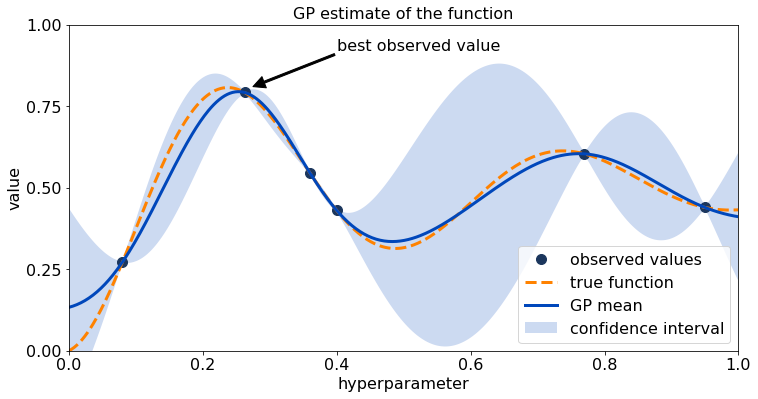

## NN

In [ ]:
def get_nn(x_tr, y_tr, x_val, y_val, shape, u1_x8=128, u2_x8=64, u3_x8=32, d1=0.5, d2=0.5, d3=0.5):
    u1 = max(int(u1_x8 * 8), 8)
    u2 = max(int(u2_x8 * 8), 8)
    u3 = max(int(u3_x8 * 8), 8)
    
    K.clear_session()
    inp = Input(shape = (x_tr.shape[1],))
    x = Dense(u1, input_dim=X.shape[1], activation='relu')(inp)
    x = Dropout(d1)(x)
    x = BatchNormalization()(x)
    x = Dense(u2, activation='relu')(x)
    x = Dropout(d2)(x)
    x = BatchNormalization()(x)
    x = Dense(u3, activation='relu')(x)
    x = Dropout(d3)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp,out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])
    
    es = EarlyStopping(monitor='CRPS_score_val', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=0, 
                       patience=10)

    mc = ModelCheckpoint('best_model.h5',monitor='CRPS_score_val',mode='min',
                                   save_best_only=True, verbose=0, save_weights_only=True)
    
    bsz = 1024
    steps = x_tr.shape[0]/bsz

    model.fit(x_tr, y_tr,callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], epochs=100, batch_size=bsz,verbose=0)
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    crps = crps_score(y_pred, y_valid, shape=shape)

    return model, crps

def fit_nn(X=X, y=y, fold=5, u1_x8=128, u2_x8=64, u3_x8=32, d1=0.5, d2=0.5, d3=0.5):
    crps_csv_nn = []  
    kfold = KFold(fold, random_state = 42, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(yards)):
        tr_x, tr_y = X[tr_inds], y[tr_inds]
        val_x, val_y = X[val_inds], y[val_inds]
        
        # Train NN
        _, crps_nn = get_nn(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0], 
                            u1_x8=u1_x8, u2_x8=u2_x8, u3_x8=u3_x8, d1=d1, d2=d2, d3=d3)
        crps_csv_nn.append(crps_nn)
        
    return -np.mean(crps_csv_nn)

In [ ]:
from bayes_opt import BayesianOptimization

pbounds = {
           'u1_x8': (15.9, 256.1),
           'u2_x8': (15.9, 256.1),
           'u3_x8': (15.9, 256.1),
           'd1': (0, 0.9),
           'd2': (0, 0.9),
           'd3': (0, 0.9),
          }

optimizer_nn = BayesianOptimization(
    f=fit_nn,
    pbounds=pbounds,
    verbose=2,
    random_state=42,
)

optimizer_nn.maximize(init_points=10, n_iter=50)

In [ ]:
print('Best Number of Neurons 1: ', max(int(optimizer_nn.max['params']['u1_x8'] * 8), 8))
print('Best Number of Neurons 2: ', max(int(optimizer_nn.max['params']['u2_x8'] * 8), 8))
print('Best Number of Neurons 3: ', max(int(optimizer_nn.max['params']['u3_x8'] * 8), 8))
print('Best Dropout Rate 1: ', round(optimizer_nn.max['params']['d1'], 5))
print('Best Dropout Rate 2: ', round(optimizer_nn.max['params']['d2'], 5))
print('Best Dropout Rate 3: ', round(optimizer_nn.max['params']['d3'], 5))

## RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def get_rf(x_tr, y_tr, x_val, y_val, shape, mf=0.3, msl=15, mss=8, ne=50):
    msl = int(msl)
    mss = int(mss)
    ne = int(ne)
    
    model = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=15, 
                                  min_samples_split=8, n_estimators=50, n_jobs=-1, random_state=42)
    model.fit(x_tr, y_tr)
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    crps = crps_score(y_pred, y_valid, shape=shape)
    
    return model, crps

def fit_rf(X=X, y=y, fold=5, mf=0.3, msl=15, mss=8, ne=50):
    crps_csv_rf = []  
    kfold = KFold(fold, random_state = 42, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(yards)):
        tr_x, tr_y = X[tr_inds], y[tr_inds]
        val_x, val_y = X[val_inds], y[val_inds]
        
        # Train NN
        _, crps_rf = get_rf(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0], 
                            mf=mf, msl=msl, mss=mss, ne=ne)
        crps_csv_rf.append(crps_rf)
        
    return -np.mean(crps_csv_rf)

In [ ]:
# pbounds = {
#            'mf': (0.1, 1.0),
#            'msl': (0.9, 20.1),
#            'mss': (1.9, 15.1),
#            'ne': (39.9, 80.1),
#           }

# optimizer_rf = BayesianOptimization(
#     f=fit_rf,
#     pbounds=pbounds,
#     verbose=2,
#     random_state=42,
# )

# optimizer_rf.maximize(init_points=5, n_iter=10)

In [ ]:
# print('max_features: ', round(optimizer_rf.max['params']['mf'], 5))
# print('min_samples_leaf: ', int(optimizer_rf.max['params']['msl']))
# print('min_samples_split: ', int(optimizer_rf.max['params']['mss']))
# print('Best n_estimators: ', int(optimizer_rf.max['params']['ne']))